In [1]:
import tensorflow as tf
from IPython.display import Image, display

import matplotlib.pyplot as plt
import tensorflow_hub as hub

import numpy as np
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvidia-smi

Sun Jun  6 06:25:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
cd /content/

/content


In [6]:
ls /content/drive/MyDrive/Datasets/cheetah_zip

cheetah_train_resized.zip       jaguar_train_resized.zip
cheetah_validation_resized.zip  jaguar_validation_resized.zip
hyena_train_resized.zip         tiger_train_resized.zip
hyena_validation_resized.zip    tiger_validation_resized.zip


In [15]:
local_zip = '/content/drive/MyDrive/Datasets/cheetah_zip/tiger_validation_resized.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/animalds/val/tiger')
zip_ref.close()

In [18]:
batch_size = 64
img_height = 224
img_width = 224

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('/tmp/animalds/train',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3600 files belonging to 4 classes.


In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('/tmp/animalds/val',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 4 classes.


In [21]:
classes=train_ds.class_names
print(classes) 

['cheetah', 'hyena', 'jaguar', 'tiger']


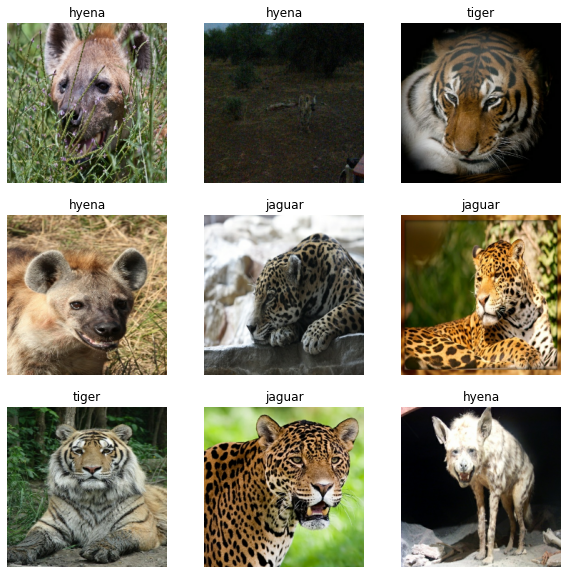

In [22]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height,img_width,3)) 

feature_extractor_layer.trainable = False

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

model = tf.keras.Sequential([
  normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(4,activation='softmax')
])

In [30]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [31]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
57/57 [==============================] - 42s 146ms/step - loss: 0.2634 - accuracy: 0.9231 - val_loss: 0.0397 - val_accuracy: 0.9950
Epoch 2/20
57/57 [==============================] - 4s 76ms/step - loss: 0.0376 - accuracy: 0.9936 - val_loss: 0.0318 - val_accuracy: 0.9950
Epoch 3/20
57/57 [==============================] - 4s 76ms/step - loss: 0.0280 - accuracy: 0.9958 - val_loss: 0.0303 - val_accuracy: 0.9950
Epoch 4/20
57/57 [==============================] - 4s 76ms/step - loss: 0.0246 - accuracy: 0.9950 - val_loss: 0.0299 - val_accuracy: 0.9950
Epoch 5/20
57/57 [==============================] - 4s 76ms/step - loss: 0.0222 - accuracy: 0.9950 - val_loss: 0.0291 - val_accuracy: 0.9950
Epoch 6/20
57/57 [==============================] - 4s 76ms/step - loss: 0.0197 - accuracy: 0.9956 - val_loss: 0.0294 - val_accuracy: 0.9950
Epoch 7/20
57/57 [==============================] - 4s 76ms/step - loss: 0.0187 - accuracy: 0.9964 - val_loss: 0.0308 - val_accuracy: 0.9950
Epoch 8/20


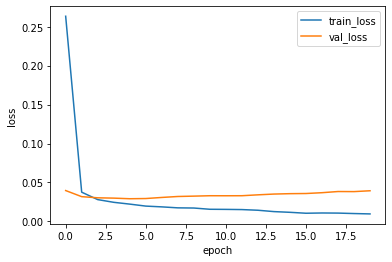

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='best')
plt.show()

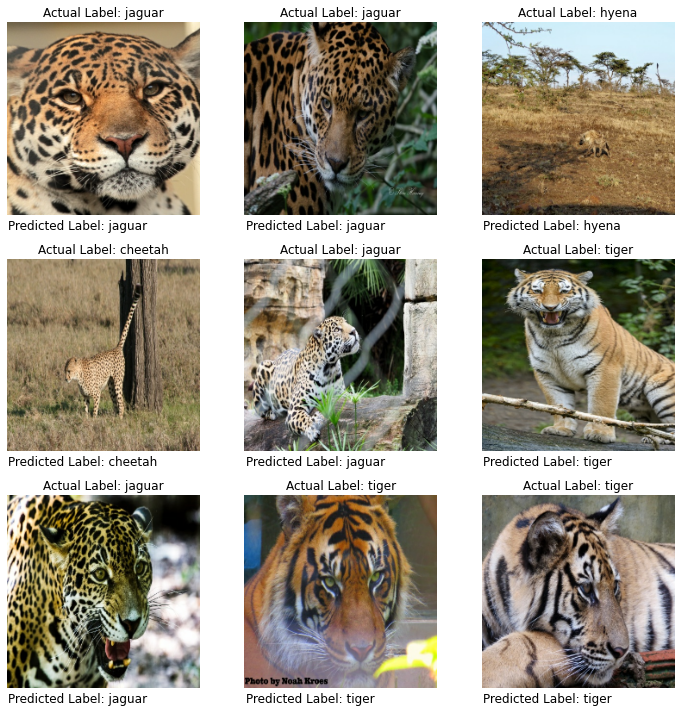

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    plt.tight_layout()
    
    img = tf.keras.preprocessing.image.img_to_array(images[i])                    
    img = np.expand_dims(img, axis=0)  

    pred=model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual Label: %s" % classes[labels[i]])
    plt.text(1, 240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize=12)

    plt.axis("off")

In [36]:
model.save('./models', save_format='tf')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [37]:
!ls -alrt models

total 2060
drwxr-xr-x 1 root root    4096 Jun  6 06:42 ..
drwxr-xr-x 2 root root    4096 Jun  6 06:42 variables
drwxr-xr-x 2 root root    4096 Jun  6 06:42 assets
-rw-r--r-- 1 root root 2083787 Jun  6 06:42 saved_model.pb
-rw-r--r-- 1 root root    6661 Jun  6 06:42 keras_metadata.pb
drwxr-xr-x 4 root root    4096 Jun  6 06:42 .


In [38]:
model_loaded = tf.keras.models.load_model('./models/')
model_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [39]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [41]:

pred_label=model_loaded.predict(process('/tmp/animalds/val/hyena/hyena_000_val_resized.jpg'))
print(classes[np.argmax(pred_label)])

hyena


In [42]:
pred_label

array([[3.4647019e-06, 9.9999392e-01, 8.8276408e-09, 2.5597888e-06]],
      dtype=float32)

In [43]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/assets/ (stored 0%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/variables/variables.index (deflated 78%)
  adding: models/saved_model.pb (deflated 92%)
  adding: models/keras_metadata.pb (deflated 81%)
